# pyWavelet Snow Radar Processor

Example of using the wavelet process with CRESIS 2-8 GHz snow radar data (MATFILE)

Note this approach is still in testing and has not been validated against in situ data.

In [11]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt

In [12]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [13]:
radar_file = "./data/sr/Data_20160419_04_010.mat"
radar_dat = snowradar.SnowRadar(radar_file, l_case='full')

Processing: C:\Users\kingj\Documents\Projects\2018-2019\250618_Wavelet\pyWavelet\pyWavelet\data\sr\Data_20160419_04_010.mat


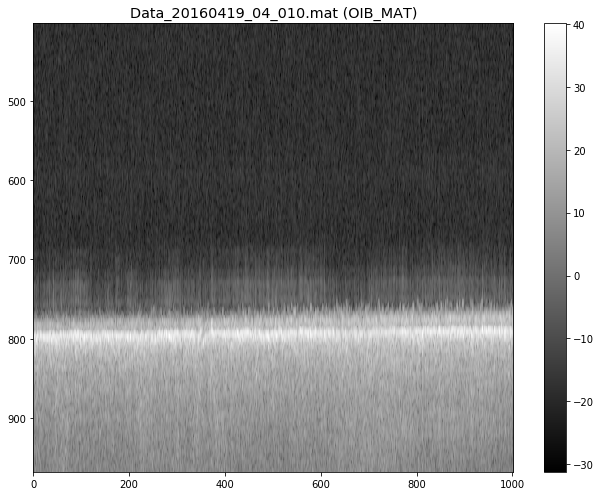

In [14]:
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()
radar_bounds = radar_dat.get_bounds(5)
radar_sub = radar_dat.data_radar[radar_bounds[1]: radar_bounds[0], :]
radar_dat.plot_quicklook(ylim = list(radar_bounds))

### Signals stuff

In [15]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.07570516616161616
0.20186025505333335


### This applies the picklayer function to every trace

In [16]:
with np.errstate(invalid='ignore', divide='ignore'):
    l_as, l_si = np.apply_along_axis(
        picklayers.picklayers, 
        0, 
        radar_sub,
        radar_dat.n2n,
        radar_dat.dfr,
        n_snow
    )

In [17]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

# Retrieval output

Max along-track resolution
Mean depth (m): 0.28251865766498313
StDev of  depth (m): 0.059994713834151565

5-bin averaged along-track 
Mean snow depth (m): 0.28258186201816227
StDev of snow depth (m): 0.04088001435239346


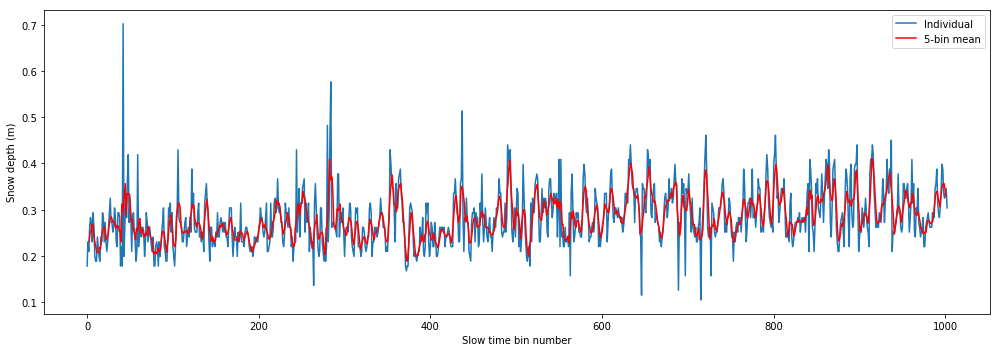

In [18]:
N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

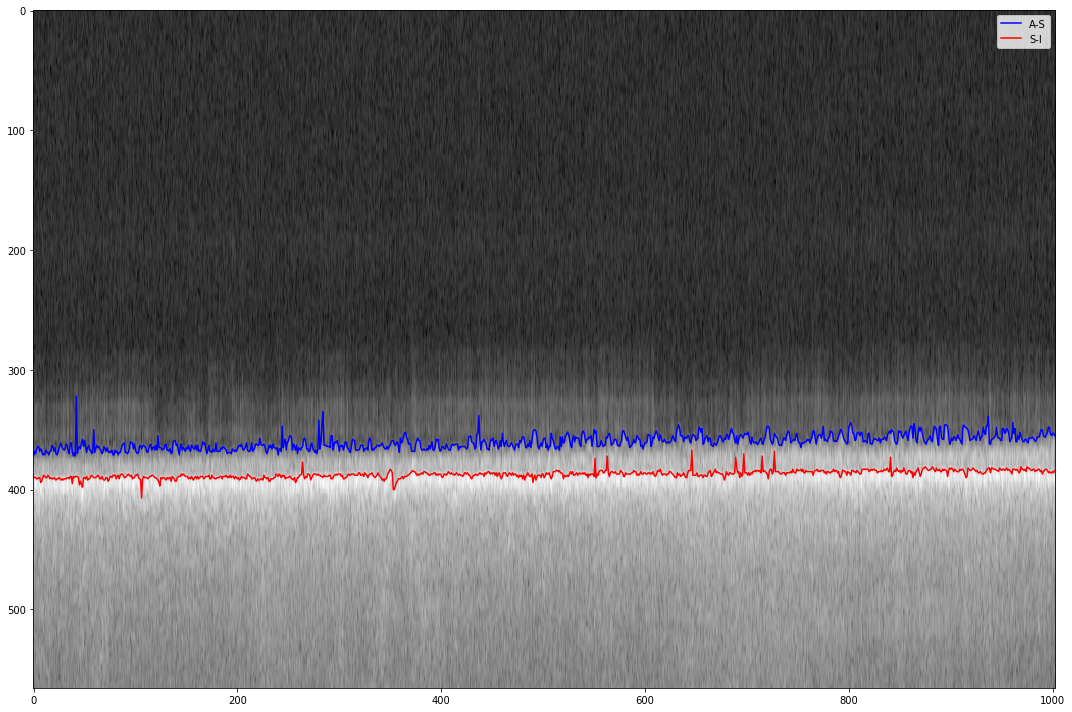

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_aspect('auto')
fig.tight_layout();

388


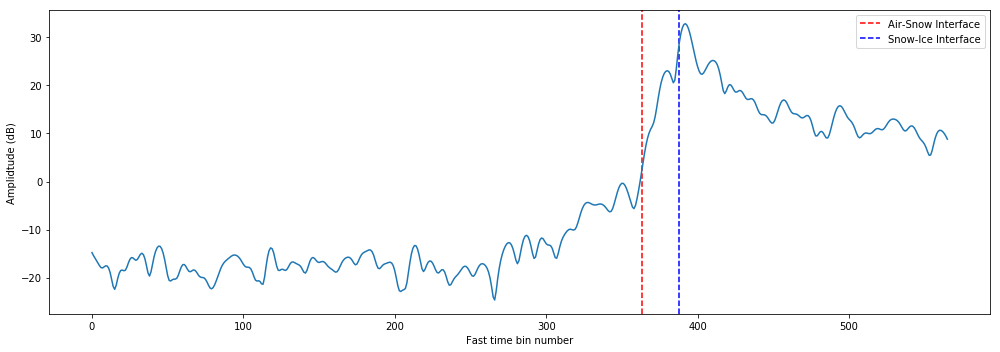

In [20]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
with np.errstate(divide='ignore'):
    ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
fig.tight_layout();